<a href="https://colab.research.google.com/github/t-willi/Simula/blob/main/testing_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
!pip install wandb
!pip install ecg_plot
import wandb
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import torch.optim as optim
from random import shuffle
from tqdm.auto import tqdm
import requests
import zipfile
from pathlib import Path

api = wandb.Api()
artifact = api.artifact('ecg_simula/setup_weights and biases/ecg_25000.zip:v0')
artifact.download()
torch.manual_seed(42)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: Downloading large artifact ecg_25000.zip:v0, 1383.92MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


In [116]:
#load model state
previous_model = api.artifact("ecg_simula/AE_pTOP_serious_try2/Model:v19", type='Model')
previous_model.download()

wandb:   1 of 1 files downloaded.  


'./artifacts/Model:v19'

In [117]:
def request(path=None,name=None):
  import requests
  from pathlib import Path
  request = requests.get(path)
  name=name+".py"
  with open(name,"wb") as f:
    f.write(request.content)

unzip_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/unzip.py"
Dataloader_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/dataset_and_loader.py"
#model_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/Networks.py"
get_pred_no_reshape_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/get_predictions_no_reshape.py"
get_pred_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/get_predictions.py"
plt_ECG_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/plot_ECG.py"

request(unzip_git_dir,"Unzip")
from Unzip import unzip

request(Dataloader_git_dir,"dataset_and_loader")
from dataset_and_loader import Custom_dataset as CD
from dataset_and_loader import make_loader as ml

#Download and instantialize model
# request(model_git_dir,"Networks")
# from Networks import ECG_stacked_AE
# model=ECG_AE_v1()

#download prediction generator
request(get_pred_no_reshape_git_dir,"get_predictions")
from get_predictions import get_pred
#download ECG plotter
request(plt_ECG_git_dir,"plot_ECG")
from plot_ECG import plotECG


In [118]:
unzip(save_path="custom_data/train",zip_path="/content/artifacts/ecg_25000.zip:v0/ecg_25000.zip")

custom_data/train directory exists.


In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class Transpose1dLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=11, upsample=None, output_padding=1):
        super(Transpose1dLayer, self).__init__()
        self.upsample = upsample
        self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        reflection_pad = kernel_size // 2
        self.reflection_pad = nn.ConstantPad1d(reflection_pad, value=0)
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        self.Conv1dTrans = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, padding, output_padding)

    def forward(self, x):
        if self.upsample:
            #x = torch.cat((x, in_feature), 1)
            return self.conv1d(self.reflection_pad(self.upsample_layer(x)))
        else:
            return self.Conv1dTrans(x)


class Pulse2pulseGenerator(nn.Module):
    def __init__(self,latent_dim=100, post_proc_filt_len=512,upsample=True):
        super(Pulse2pulseGenerator, self).__init__()
        # "Dense" is the same meaning as fully connection.
        stride = 4
        if upsample:
            stride = 1
            upsample = 5
        # if upsample is anything but none Transpose1dLayer will do
        # self.conv1d(self.reflection_pad(self.upsample_layer(x)))
        # which is a 1d convolution on padded and upsampled data x
        self.deconv_1 = Transpose1dLayer(250 , 250, 25, stride, upsample=upsample)
        self.deconv_2 = Transpose1dLayer(250, 150, 25, stride, upsample=upsample)
        self.deconv_3 = Transpose1dLayer(150, 50, 25, stride, upsample=upsample)
        self.deconv_4 = Transpose1dLayer( 50, 25, 25, stride, upsample=2)
        self.deconv_5 = Transpose1dLayer( 25, 10, 25, stride, upsample=upsample)
        self.deconv_6 = Transpose1dLayer(  10, 7, 25, stride, upsample=2)

        #new convolutional layers
        self.conv_1 = nn.Conv1d(1, 10, 25, stride=2, padding=25 // 2)
        self.conv_2 = nn.Conv1d(10, 25, 25, stride=5, padding= 25 // 2)
        self.conv_3 = nn.Conv1d(25, 50 , 25, stride=2, padding= 25 // 2)
        self.conv_4 = nn.Conv1d(50, 150 , 25, stride=5, padding= 25 // 2)
        self.conv_5 = nn.Conv1d(150, 250 , 25, stride=5, padding= 25 // 2)
        self.conv_6 = nn.Conv1d(250, 250 , 25, stride=5, padding= 25 // 2)

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)

    def forward(self, x):
        if x.ndim==2:
          x=x.unsqueeze(0)
        x = F.leaky_relu(self.conv_1(x)) #(1,1,5000 --> 1, 10, 2500)
        x = F.leaky_relu(self.conv_2(x)) #( --> 1, 25, 500)
        x = F.leaky_relu(self.conv_3(x)) #(--> 1, 50, 250)
        x = F.leaky_relu(self.conv_4(x)) # --> 1, 150, 50)
        x = F.leaky_relu(self.conv_5(x)) #(--> 1, 250, 10)
        x = F.leaky_relu(self.conv_6(x)) #(--> 1, 250, 2)
        x = F.relu(self.deconv_1(x)) #(--> 1, 250, 10)
        x = F.relu(self.deconv_2(x)) #(--> 1, 150, 50)
        x = F.relu(self.deconv_3(x)) #( --> 1, 50, 250)
        x = F.relu(self.deconv_4(x)) #(--> 1, 25, 500)
        x = F.relu(self.deconv_5(x)) #(--> 1, 10, 2500)
        x = torch.tanh(self.deconv_6(x)) #(1, 7, 5000)
        x=x.squeeze()
        return x

model=Pulse2pulseGenerator()
# PATH="/content/artifacts/Model:v19/model"
# model.load_state_dict(torch.load(PATH))

In [120]:
data_dir="custom_data/train"
test_dataset = CD(data_dir=data_dir,split=True,target="test")
model.to("cpu")
input,output=get_pred(test_dataset,model=model)
combined_df=plotECG(input,output,path="/content/testECG")

  

/content/testECG directory exists.


In [121]:
import torch
import pandas as pd

def get_pred(dataset=None,Set=None,model=None,random=True):
  """
  Function takes a Tensor Dataset as input,first a random file from the dataset is selected,
  then the Tensor pair is recombined and shaped into a df-->df_Input. 
  X is used afterwards as input into the model. The predictions are safed as --> df_output.
  Both dataframes are now unscaled by 5011, the max value of the whole dataset.
  Then a tuple pair of input and output is returned.
  """
  if random:
    import random
    limit=len(dataset)
    rand_idx=random.randint(0,limit)
    X,y=dataset[rand_idx]
  if random is False:
      X,y=Set
  #need to combine tensors to make dataframe for plotting input and output side by side
  full_tensor=torch.cat((X,y.squeeze()))
  full_tensor=full_tensor.numpy()
  df_input=pd.DataFrame(full_tensor).T
  df_input.columns = ["R1","R2","Rv1","Rv2","Rv3","Rv4","Rv5","Rv6"]
  model.to("cpu")
  model.eval()
  with torch.inference_mode():
    output=model(X)
  output=output.detach().numpy()
  output=output.squeeze().T
  #unscale data
  df_output = pd.DataFrame(output,columns=["F2","Fv1","Fv2","Fv3","Fv4","Fv5","Fv6"])*5011
  df_input=df_input*5011
  return df_input,df_output

In [122]:
import pandas as pd
from pathlib import Path
def plotECG(df1=None,df2=None,title=None,pad_df2=True,path=None,createECG=True):
  """
  takes two dataframes with identical columns, concats them and plots them as ecg using ecg_plot
  it also takes the first column of df1 and ads it to df1 if pad_df2 is True
  """
  index=["real1","realR2","realv1","realv2","realv3","realv4","realv5","realv6","real_lead1",
         "pred2","predv1","predv2","predv3","predv4","predv5","predv6"]
  if createECG==True:
    ecg_path=path
    if Path(ecg_path).is_dir():
        print(f"{ecg_path} directory exists.")
    else:
        print(f"Did not find {ecg_path} directory, creating one...")
        Path(ecg_path).mkdir(parents=True, exist_ok=True)
    import ecg_plot
  if pad_df2 is True:
    if len(df1.columns)>len(df2.columns):
      df2.insert(0, 'real_lead1', df1["R1"])
  frames=[df1/1000,df2/1000]
  combined_df=pd.concat(frames,axis=1,join="outer",)
  if createECG is True:
    ecg_plot.plot(combined_df.values.T, sample_rate = 500,title = title,
                      lead_index = index )
    ecg_plot.save_as_png('ecg',ecg_path+"/")
  return combined_df

In [395]:
model=Pulse2pulseGenerator()
PATH="/content/artifacts/Model:v19/model"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [396]:
all_loss_list=[]
all_loss_over_time_list=[]
all_lead_pair_list=[]
for Set in tqdm(test_dataset):
  df_in,df_out=get_pred(Set=Set,model=model,random=False)
  combined_df=plotECG(df_in,df_out,createECG=False)
  #list of averages losses betwen lead pairs
  loss_list=[]
  #list of losses between lead pairs over time
  loss_over_time_list=[]
  #lead pair list for plotting lead pairs on top of each other
  lead_pair_list=[]
  criterion = nn.MSELoss()
  #going over all columns in combined dataframe
  for i in range(8):
    t1=(torch.Tensor(combined_df.iloc[:,i]))
    t2=(torch.Tensor(combined_df.iloc[:,i+8]))
    lead_pair=(t1,t2)
    lead_pair_list.append(lead_pair)
    loss=criterion(t1,t2)
    loss_list.append(loss)
    loss_over_time=(t1-t2)**2
    loss_over_time_list.append(loss_over_time) 
  all_loss_list.append(loss_list)
  all_loss_over_time_list.append(loss_over_time_list)
  all_lead_pair_list.append(lead_pair_list)

  
  

  0%|          | 0/2500 [00:00<?, ?it/s]

In [325]:
all_loss_over_time_list[0][7]

tensor([0.0013, 0.0018, 0.0079,  ..., 0.0050, 0.0075, 0.0026])

In [397]:
#get average loss over time
loss1=torch.empty(1,5000)
loss2=torch.empty(1,5000)
loss3=torch.empty(1,5000)
loss4=torch.empty(1,5000)
loss5=torch.empty(1,5000)
loss6=torch.empty(1,5000)
loss7=torch.empty(1,5000)
loss8=torch.empty(1,5000)
List_of_average_losses=[loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8]
for k,loss_list in tqdm(enumerate(all_loss_over_time_list)):
  for i in range(8):
    List_of_average_losses[i]+=loss_list[i]
for item in List_of_average_losses:
  item/=2500




0it [00:00, ?it/s]

In [398]:
loss_dict={"I":0,
          "II":0,
          "v1":0,
          "v2":0,
          "v3":0,
          "v4":0,
          "v5":0,
          "v6":0}
dictionaryofleads={"0":"I",
                  "1":"II",
                  "2":"v1",
                  "3":"v2",
                  "4":"v3",
                  "5":"v4",
                  "6":"v5",
                  "7":"v6"}
for k,loss_list in tqdm(enumerate(all_loss_list)):
  for i in range(8):
    t1=(torch.Tensor(combined_df.iloc[:,i]))
    t2=(torch.Tensor(combined_df.iloc[:,i+8]))
    loss=criterion(t1,t2)
    index=dictionaryofleads[f"{i}"]
    loss_dict[index]+=loss
result = {key: value / len(all_loss_list) for key, value in loss_dict.items()}

  






0it [00:00, ?it/s]

In [399]:
result

{'I': tensor(0.),
 'II': tensor(0.0157),
 'v1': tensor(0.0147),
 'v2': tensor(0.0227),
 'v3': tensor(0.0147),
 'v4': tensor(0.0117),
 'v5': tensor(0.0088),
 'v6': tensor(0.0069)}

<All keys matched successfully>

In [400]:
#create lists for averge loss and loss over time from random samples
df_1,df_2=get_pred(dataset=test_dataset,Set=None,model=model,random=True)
combined_df=plotECG(df_1,df_2,path=None,createECG=False)
#list of averages losses betwen lead pairs
loss_list=[]
#list of losses between lead pairs over time
loss_over_time_list=[]
#lead pair list for plotting lead pairs on top of each other
lead_pair_list=[]
criterion = nn.MSELoss()
#going over all columns in combined dataframe
for i in range(8):
  t1=(torch.Tensor(combined_df.iloc[:,i]))
  t2=(torch.Tensor(combined_df.iloc[:,i+8]))
  lead_pair=(t1,t2)
  lead_pair_list.append(lead_pair)
  loss=criterion(t1,t2)
  loss_list.append(loss)
  loss_over_time=(t1-t2)**2
  loss_over_time_list.append(loss_over_time)




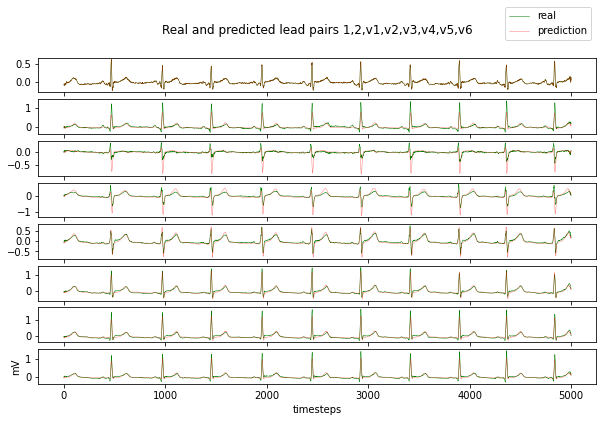

In [401]:
fig,axs=plt.subplots(8,figsize=(10,6))
plt.ylabel("mV")
plt.xlabel("timesteps")
plt.title("Real and predicted lead pairs 1,2,v1,v2,v3,v4,v5,v6", x=0.5,y=9.9)
for k,(real,synth) in enumerate(lead_pair_list):
  axs[k].plot(real.tolist(),label="real",linewidth=0.5,c="g",alpha=1)
  axs[k].plot(synth.tolist(),label="prediction",linewidth=0.5,c="r",alpha=0.5)
plt.legend(loc=1, bbox_to_anchor=(1,11))
plt.savefig(f"ECG_pairs{k}.pdf", format="pdf", bbox_inches="tight")

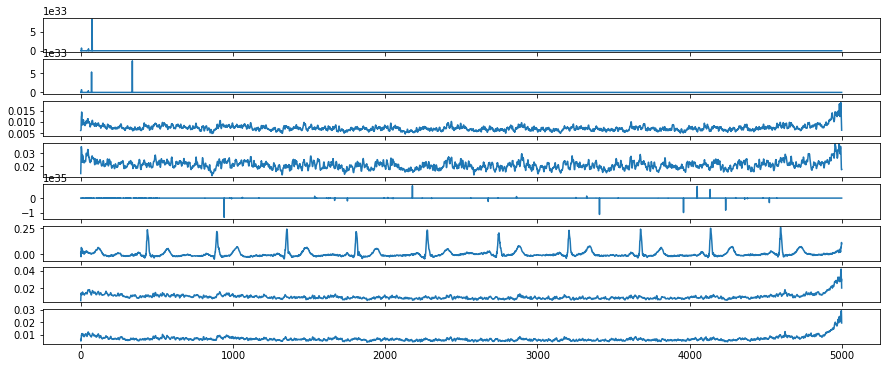

In [402]:
def plot_ECG_loss_over_time(input=None):
  """
  enter a list of losses over time 
  """
  import matplotlib.pyplot as plt
  fig, axs = plt.subplots(8,figsize=(15,6))

  for k,item in enumerate(input):
    axs[k].plot(item.squeeze())

plot_ECG_loss_over_time(List_of_average_losses)